In [33]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)


In [8]:
#download MNIST data
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )
     

In [9]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


0


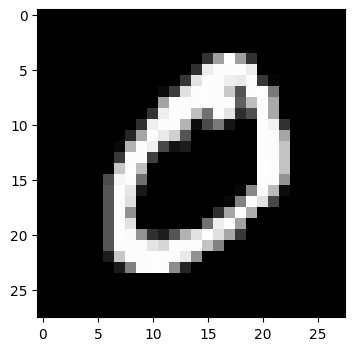

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Index number of an instance (change this to view another instance).
i = 1

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image, cmap='gray')
plt.show()
     

In [34]:
import numpy as np

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))         # Flatten: (N x 28 x 28) -> (N x 784)
    return X

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])   # (60000 x 784)
Ytrain = data['train_y']                    # (60000)
Xtest = image_to_vector(data['test_x'])     # (10000 x 784)
Ytest = data['test_y']                      # (10000)

#permute the data
#np.random.seed(0)
#perm = np.random.permutation(len(Xtrain))
#Xtrain = Xtrain[perm]
#Ytrain = Ytrain[perm]

In [45]:
def leaky_relu(X):
	return tf.select(X > 0.0, X, 0.01 * X)

def forward(W, X, b):
    L1 = tf.matmul(W, X)
    L1 = L1 + b[L1.indices[1]]
    L2 = leaky_relu(L1)
    return L2

def loss(Y, Yhat):
    elements = Y.shape[1] * Y.shape[0]
    return tf.sum(tf.sum((Y - Yhat) ** 2.0)) / tf.float(elements)

def backward(W, X, b, Y, Yhat):
    dL2 = 2.0 * (Yhat - Y)
    dL1 = tf.select(Yhat > 0.0, dL2, 0.01 * dL2)
    dW = tf.matmul(dL1, X.T)
    db = tf.sum(dL1, axis = 1)
    return dW, db

def update(W, X, b, dW, db, lr):
    W -= lr * dW
    b -= lr * db
    return W, b

def step():
    W = tf.input([-1, -1], tf.float32)
    Out, In = W.shape
    X = tf.input([In, -1], tf.float32)
    b = tf.input([Out], tf.float32)
    Samples = X.shape[1]
    Y = tf.input([Out, Samples], tf.float32)
    Yhat = forward(W, X, b)
    L = loss(Y, Yhat)
    dW, db = backward(W, X, b, Y, Yhat)
    W, b = update(W, X, b, dW, db, 0.001)

    return [Yhat, L, W, b]

fwd = tf.compile(step)


step:
  Kernel count: 9
  Intermediate buffers: 7
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 444
  IR Compile time: 69.956306 ms
  Compiler time: 1746.814575 ms



In [46]:
TrainSamples = 1024
Xsamples = Xtrain[:TrainSamples].T
Ysamples = np.zeros((10, TrainSamples))
Ysamples[Ytrain[:TrainSamples], np.arange(TrainSamples)] = 1.0

print (Xsamples.shape)
print (Ysamples.shape)

W = np.random.randn(10, 28*28)          # (10 x 785)
b = np.random.randn(10)                   # (10)

(784, 1024)
(10, 1024)


In [47]:
Wtf = tf.tensor(W)
btf = tf.tensor(b)
Xtf = tf.tensor(Xsamples)
Ytf = tf.tensor(Ysamples)

#for i in range(30):
#    Yhat, L, Wtf, btf = fwd(Wtf, Xtf, btf, Ytf)
#    print("Loss: ", L.numpy)

epochs = 100
iterations = 100

for i in range(epochs):
    avg_loss = 0
    for j in range(iterations):
        Yhat, L, Wtf, btf = fwd(Wtf, Xtf, btf, Ytf)
        avg_loss += L.numpy
    print("Epoch: ", i, " Loss: ", avg_loss / iterations)

Epoch:  0  Loss:  [9.767156]
Epoch:  1  Loss:  [2.1540244]
Epoch:  2  Loss:  [0.5607424]
Epoch:  3  Loss:  [0.217234]
Epoch:  4  Loss:  [0.14406332]
Epoch:  5  Loss:  [0.12176681]
Epoch:  6  Loss:  [0.11305013]
Epoch:  7  Loss:  [0.106271]
Epoch:  8  Loss:  [0.10400663]
Epoch:  9  Loss:  [0.10089896]
Epoch:  10  Loss:  [0.10073254]
Epoch:  11  Loss:  [0.10036767]
Epoch:  12  Loss:  [0.10042464]
Epoch:  13  Loss:  [0.10271569]
Epoch:  14  Loss:  [0.10192233]
Epoch:  15  Loss:  [0.10292225]
Epoch:  16  Loss:  [0.10326263]
Epoch:  17  Loss:  [0.10633186]
Epoch:  18  Loss:  [0.10422324]
Epoch:  19  Loss:  [0.1043802]
Epoch:  20  Loss:  [0.10617748]
Epoch:  21  Loss:  [0.10738812]
Epoch:  22  Loss:  [0.10494015]
Epoch:  23  Loss:  [0.10754273]
Epoch:  24  Loss:  [0.10997789]
Epoch:  25  Loss:  [0.11045375]
Epoch:  26  Loss:  [0.11017834]
Epoch:  27  Loss:  [0.11054774]
Epoch:  28  Loss:  [0.11386]
Epoch:  29  Loss:  [0.11196651]
Epoch:  30  Loss:  [0.1106842]
Epoch:  31  Loss:  [0.11052721]